In [5]:
!pip3 install nltk

     |████████████████████████████████| 1.5 MB 32.2 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 749 kB 54.4 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 7.8 MB/s  eta 0:00:01
     |████████████████████████████████| 306 kB 56.3 MB/s eta 0:00:01


In [6]:
import pandas as pd
import requests
import os
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
import string

bearer_token = 'AAAAAAAAAAAAAAAAAAAAALsfdAEAAAAAg5EP0Vrt%2BAyIksX0kDNaXrckI18%3DcVboUIsTTAdb9bTgWzXh5sCIUGFAFP4RswK5frgboOQgQEQKDa'

api_url = "https://api.twitter.com/"

query_params = {'query': '("sabesp") -is:retweet is:verified lang:pt','tweet.fields': 'author_id'}


def bearer_oauth(r):
    """
    Método exigido pela autenticação do token do portador.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def search_recent_tweets(query):
    response = requests.get(
        api_url + '2/tweets/search/recent', 
        auth=bearer_oauth, 
        params={
            "query": query,
            "max_results": 100,
            "tweet.fields":'author_id',
            "expansions":"author_id"
        }
    )

    if response.status_code != 200:
        raise Exception(response.status_code, response.text)

    return json.loads(response.text)

In [7]:
SEARCH_WORD = 'saneamento básico'
data = search_recent_tweets(f'("{SEARCH_WORD}") -is:retweet is:verified lang:pt')

In [8]:
nltk.download('stopwords')
PREPOSICAO = [*stopwords.words('portuguese'), 'pra', 'tá', 'q', 'o', 'tô']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
def remove_preposicao(text):
    new_text = ' '.join([k for k in text.split(" ") if k not in PREPOSICAO])
    return new_text

In [10]:
dataframe = pd.DataFrame.from_dict(data['data'])
dataframeUser = pd.DataFrame.from_dict(data['includes']['users'])
df = dataframe.merge(dataframeUser, left_on='author_id', right_on='id')

In [11]:
def tratamento(text):
    text_sem_pontuacao = ''.join([p for p in text if p not in string.punctuation])
    text_sem_preposicao = ' '.join([k for k in text_sem_pontuacao.lower().split(" ") if k not in PREPOSICAO])
    text_formatado = ' '.join([k for k in text_sem_preposicao.split(" ") if k.lower() not in SEARCH_WORD])
    text_formatado = ' '.join([k for k in text_formatado.split(" ") if not k.lower().startswith(SEARCH_WORD)])
    text_formatado = ' '.join([k for k in text_formatado.split(" ") if not k.lower().endswith(SEARCH_WORD)])
    return text_formatado.replace('\\n', '').replace('\n','').replace('\\','')

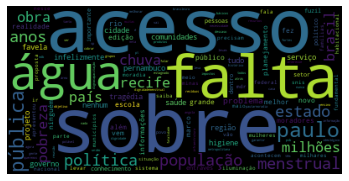

In [12]:
text = df['text'].map(tratamento).values 

wordcloud = WordCloud().generate(str(text))
wordcloud.to_file('wordCloud.png')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()